In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tqdm import tqdm
from lightgbm import LGBMClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier

In [2]:
#!python -m spacy download en_core_web_md


In [3]:
nlp = spacy.load("en_core_web_md")

In [4]:
df = pd.read_csv("cleaned_data.csv")
y = df['decision']

In [5]:
with nlp.disable_pipes("tagger", "parser", "ner"):
    resume_emb = np.array([nlp(text).vector for text in tqdm(df['resume_Text'], desc="Embedding resumes")])
    job_emb = np.array([nlp(text).vector for text in tqdm(df['job_description_text'], desc="Embedding jobs")])

X = np.concatenate([resume_emb, job_emb], axis=1)


Embedding resumes:   0%|          | 0/4829 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Embedding jobs: 100%|██████████| 4829/4829 [02:07<00:00, 37.80it/s]


In [6]:
X_reduced = PCA(n_components=100).fit_transform(X)

In [7]:
train_accuracies = {}
test_accuracies = {}

In [8]:
def evaluate_model_acc(name, model, keras=False):
    if keras:
        train_pred = (model.predict(X_train).flatten() >= 0.5).astype(int)
        test_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
    train_accuracies[name] = accuracy_score(y_train, train_pred)
    test_accuracies[name] = accuracy_score(y_test, test_pred)

In [9]:
#Cosine Similarity Baseline
cosine_scores = cosine_similarity(resume_emb, job_emb).diagonal()
df['spacy_cosine_score'] = cosine_scores
cosine_pred = (cosine_scores >= 0.5).astype(int)
cosine_acc = accuracy_score(y, cosine_pred)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, stratify=df['job_id'], test_size=0.2, random_state=42)

In [11]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
df['spacy_lr_score'] = lr_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("Logistic Regression", lr_model)

In [12]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
df['spacy_rf_score'] = rf_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("Random Forest", rf_model)

In [13]:
#LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
df['spacy_svc_score'] = svc_model.decision_function(X_reduced)
evaluate_model_acc("LinearSVC", svc_model)

In [14]:
#XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
df['spacy_xgb_score'] = xgb_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("XGBoost", xgb_model)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
#LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
df['spacy_lgb_score'] = lgb_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("LightGBM", lgb_model)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2093, number of negative: 1770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 3863, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541807 -> initscore=0.167619
[LightGBM] [Info] Start training from score 0.167619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
#Keras Neural Network
nn_model = Sequential([
    Dense(256, activation='relu', input_dim=X_reduced.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_nn = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)
df['spacy_nn_score'] = nn_model.predict(X_reduced).flatten()
evaluate_model_acc("Keras NN", nn_model, keras=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [17]:
#Naive Bayes (Gaussian)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
df['spacy_nb_score'] = nb_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("Naive Bayes", nb_model)

In [18]:
#K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
df['spacy_knn_score'] = knn_model.predict_proba(X_reduced)[:, 1]
evaluate_model_acc("KNN", knn_model)

In [19]:
#Siamese Network
X1 = resume_emb
X2 = job_emb
y_array = np.array(df['decision'])
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y_array, stratify=df['job_id'], test_size=0.2, random_state=42)

embedding_dim = X1.shape[1]
input_a = Input(shape=(embedding_dim,))
input_b = Input(shape=(embedding_dim,))

def build_shared_network(input_dim):
    x = Input(shape=(input_dim,))
    h = Dense(256, activation='relu')(x)
    h = Dropout(0.3)(h)
    h = Dense(128, activation='relu')(h)
    return Model(x, h)

shared_network = build_shared_network(embedding_dim)
encoded_a = shared_network(input_a)
encoded_b = shared_network(input_b)

l1_distance = Lambda(
    lambda tensors: tf.abs(tensors[0] - tensors[1]),
    output_shape=lambda input_shapes: input_shapes[0]
)
merged = l1_distance([encoded_a, encoded_b])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_siamese = siamese_model.fit([X1_train, X2_train], y_train, validation_data=([X1_test, X2_test], y_test), batch_size=32, epochs=10, verbose=0)
df['spacy_siamese_score'] = siamese_model.predict([X1, X2]).flatten()

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
train_pred_siamese = (siamese_model.predict([X1_train, X2_train]).flatten() >= 0.5).astype(int)
test_pred_siamese = (siamese_model.predict([X1_test, X2_test]).flatten() >= 0.5).astype(int)
train_accuracies['Siamese NN'] = accuracy_score(y_train, train_pred_siamese)
test_accuracies['Siamese NN'] = accuracy_score(y_test, test_pred_siamese)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [21]:
def print_all_model_accuracies():
    print("\n📊 Train vs Test Accuracy Summary:")
    print(f"{'Model':<20} {'Train Accuracy':<18} {'Test Accuracy':<18}")
    print("-" * 60)
    for name in train_accuracies:
        print(f"{name:<20} {train_accuracies[name]:<18.4f} {test_accuracies[name]:<18.4f}")

print_all_model_accuracies()
print(f"Cosine Similarity: Accuracy = {cosine_acc:.4f}")


📊 Train vs Test Accuracy Summary:
Model                Train Accuracy     Test Accuracy     
------------------------------------------------------------
Logistic Regression  0.6101             0.5818            
Random Forest        1.0000             0.6480            
LinearSVC            0.6223             0.5642            
XGBoost              1.0000             0.6532            
LightGBM             0.9964             0.6315            
Keras NN             0.7963             0.6408            
Naive Bayes          0.5866             0.5787            
KNN                  0.7587             0.6170            
Siamese NN           0.6112             0.5880            
Cosine Similarity: Accuracy = 0.5413


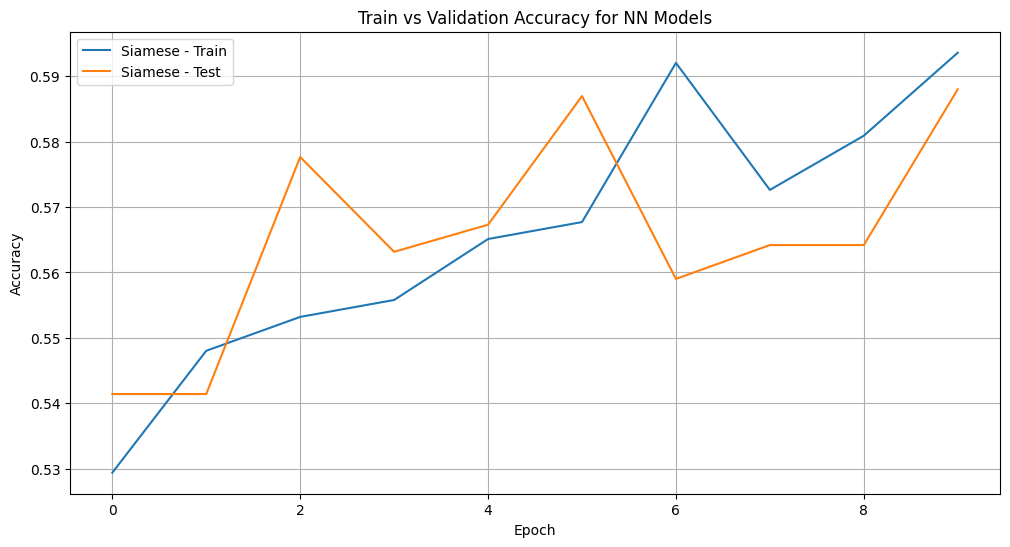

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history_siamese.history['accuracy'], label='Siamese - Train')
plt.plot(history_siamese.history['val_accuracy'], label='Siamese - Test')
plt.title('Train vs Validation Accuracy for NN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

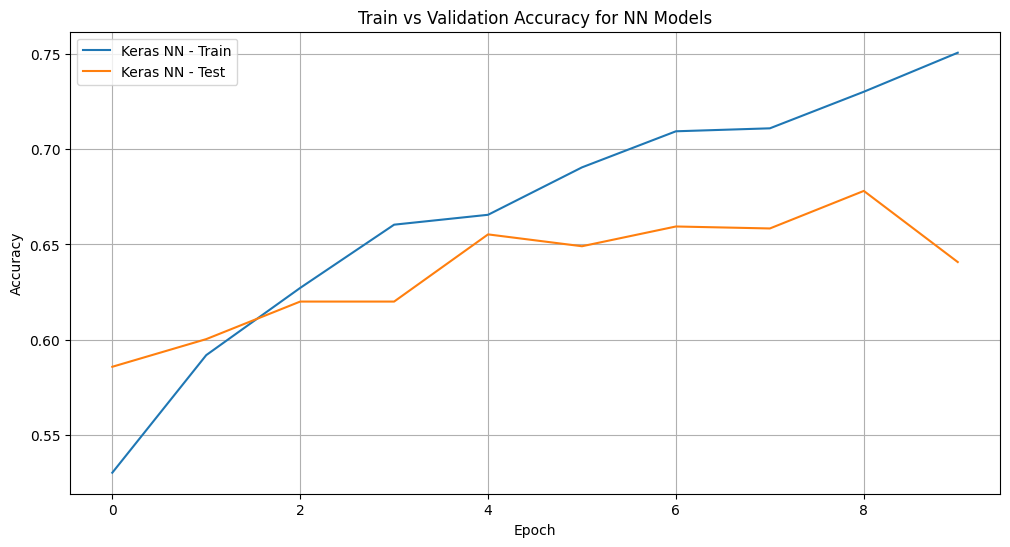

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['accuracy'], label='Keras NN - Train')
plt.plot(history_nn.history['val_accuracy'], label='Keras NN - Test')
plt.title('Train vs Validation Accuracy for NN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

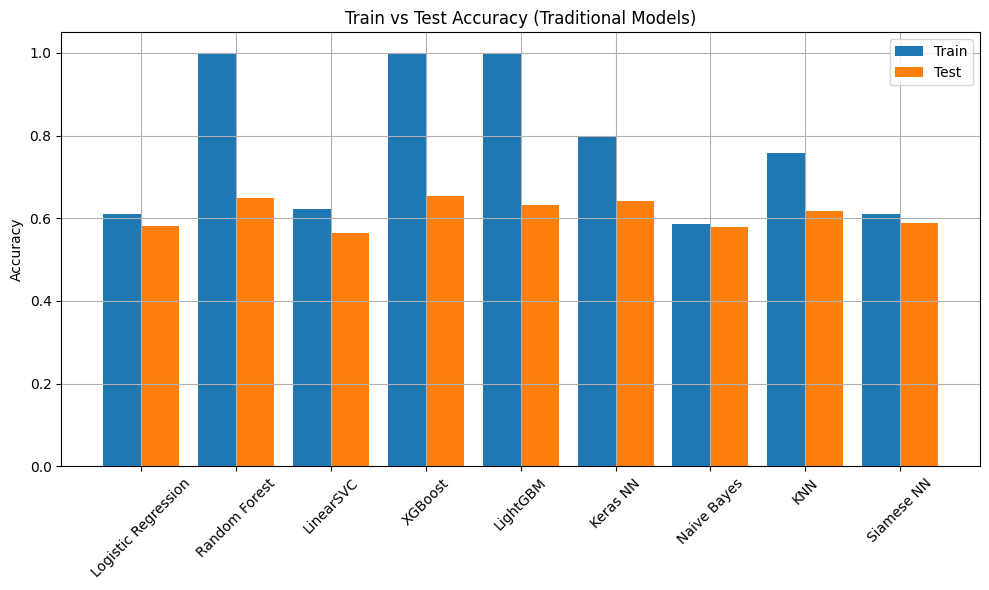

In [24]:
plt.figure(figsize=(10, 6))
labels = list(train_accuracies.keys())
train_vals = list(train_accuracies.values())
test_vals = list(test_accuracies.values())

x = range(len(labels))
plt.bar([i - 0.2 for i in x], train_vals, width=0.4, label='Train')
plt.bar([i + 0.2 for i in x], test_vals, width=0.4, label='Test')
plt.xticks(x, labels, rotation=45)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Traditional Models)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [25]:
df[[
    'job_id', 'decision',
    'spacy_lr_score','spacy_rf_score', 'spacy_svc_score',
    'spacy_xgb_score', 'spacy_lgb_score','spacy_nn_score', 'spacy_nb_score', 'spacy_knn_score',
    'spacy_siamese_score']].to_csv("spacy_model_scores.csv", index=False)